In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.preprocessing import LabelEncoder
import math
from timeit import default_timer as timer
import reverse_geocoder as rg
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

pd.options.display.float_format = "{:.6f}".format

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
yel2019 = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/yellow_tripdata_2016-06.csv")
#yel2019 = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/yellow_tripdata_2016-06.csv")

In [3]:
#boros = pd.read_csv("/Users/james.fung/Downloads/nybb (1).csv")
#boros = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/nybb.csv")

In [4]:
#centroids = pd.read_csv("/Users/jamesfung/Dropbox/Resumes/Resume/NYC/2020_resume/challenges/via/NHoodNameCentroids.csv")
centroids = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/NHoodNameCentroids.csv")

In [5]:
yel2019.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.790000,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.000000,0.500000,0.500000,0.000000,0.000000,0.300000,7.300000
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.220000,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.000000,0.500000,0.500000,4.000000,0.000000,0.300000,27.300000
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.260000,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.500000,0.500000,0.500000,1.560000,0.000000,0.300000,9.360000
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.390000,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.000000,0.500000,0.500000,1.000000,0.000000,0.300000,28.300000
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.100000,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.500000,0.500000,0.500000,2.960000,0.000000,0.300000,17.760000
5,2,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.170000,-73.995201,40.739491,1,N,-73.993202,40.762642,1,10.500000,0.500000,0.500000,2.360000,0.000000,0.300000,14.160000
6,2,2016-06-09 21:06:36,2016-06-09 21:30:13,5,6.020000,-73.980476,40.741680,1,N,-73.902962,40.748741,2,21.500000,0.500000,0.500000,0.000000,0.000000,0.300000,22.800000
7,1,2016-06-09 21:06:37,2016-06-09 21:16:47,1,1.400000,-73.985703,40.746742,1,N,-73.982506,40.762772,1,8.500000,0.500000,0.500000,1.950000,0.000000,0.300000,11.750000
8,1,2016-06-09 21:06:37,2016-06-09 21:15:44,1,1.200000,-73.984276,40.775009,1,N,-73.968498,40.766430,2,8.000000,0.500000,0.500000,0.000000,0.000000,0.300000,9.300000
9,1,2016-06-09 21:06:37,2016-06-09 21:23:57,2,1.900000,-73.977921,40.750092,1,N,-73.987236,40.749359,1,12.000000,0.500000,0.500000,3.330000,0.000000,0.300000,16.630000


In [6]:
yel2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135470 entries, 0 to 11135469
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.6+ GB


### Preliminary Feature Extraction

Let's first extract some useful information from tpep_pickup_datetime. Things such as day of the week, day of month, month, and trip duration.

In [7]:
#Create a column for the clean date.
yel2019['clean_pickup_datetime'] = pd.to_datetime(yel2019['tpep_pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
yel2019['clean_dropoff_datetime'] = pd.to_datetime(yel2019['tpep_dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')

In [8]:
#Extract day of the week, day of month, and month.
pickup = yel2019['clean_pickup_datetime']
dropoff = yel2019['clean_dropoff_datetime']
yel2019['month'] = pickup.dt.month
yel2019['dom'] = pickup.dt.day
yel2019['dow'] = pickup.dt.dayofweek

In [9]:
#Extract the duration of the trip.
yel2019['diff_sec'] = (dropoff-pickup)/np.timedelta64(1,'s')

In [10]:
#Drop the unecessary columns.
yel2019 = yel2019.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1)

In [11]:
#Filter to the first full week of June.
yel2019 = yel2019[(yel2019.clean_pickup_datetime >= datetime.datetime(2016,6,6)) & 
        (yel2019.clean_pickup_datetime >= datetime.datetime(2016,6,12)) &
        (yel2019.clean_dropoff_datetime >= datetime.datetime(2016,6,6)) & 
        (yel2019.clean_dropoff_datetime >= datetime.datetime(2016,6,12))]

In [12]:
yel2019.head(10)

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,clean_pickup_datetime,clean_dropoff_datetime,month,dom,dow,diff_sec
2166219,1,2,6.200000,-73.987473,40.719814,1,N,-73.982094,40.777905,1,...,4.000000,0.000000,0.300000,30.800000,2016-06-12 02:13:55,2016-06-12 02:44:21,6,12,6,1826.000000
2166220,2,3,9.960000,-73.993614,40.724579,1,N,-73.939842,40.825260,2,...,0.000000,0.000000,0.300000,32.300000,2016-06-12 02:13:55,2016-06-12 02:45:40,6,12,6,1905.000000
2166221,2,1,0.390000,-73.958977,40.712242,1,N,-73.960892,40.709236,1,...,1.260000,0.000000,0.300000,7.560000,2016-06-12 02:13:55,2016-06-12 02:18:39,6,12,6,284.000000
2166222,2,1,2.900000,-73.983215,40.726261,1,N,-74.008621,40.740536,1,...,0.000000,0.000000,0.300000,15.300000,2016-06-12 02:13:55,2016-06-12 02:33:02,6,12,6,1147.000000
2166223,1,1,3.700000,-73.978172,40.762932,1,N,-73.920715,40.743229,2,...,0.000000,0.000000,0.300000,14.300000,2016-06-12 02:13:56,2016-06-12 02:24:31,6,12,6,635.000000
2166224,1,3,1.200000,-74.002167,40.729591,1,Y,-74.006485,40.739384,2,...,0.000000,0.000000,0.300000,7.800000,2016-06-12 02:13:56,2016-06-12 02:21:02,6,12,6,426.000000
2166225,2,4,3.160000,-74.008377,40.740429,1,N,-73.974640,40.756489,1,...,2.860000,0.000000,0.300000,17.160000,2016-06-12 02:13:56,2016-06-12 02:29:00,6,12,6,904.000000
2166226,2,4,0.620000,-73.961525,40.780048,1,N,-73.967079,40.772663,1,...,1.320000,0.000000,0.300000,6.620000,2016-06-12 02:13:56,2016-06-12 02:15:28,6,12,6,92.000000
2166227,2,5,2.330000,-73.979408,40.749969,1,N,-74.007500,40.734268,1,...,2.160000,0.000000,0.300000,12.960000,2016-06-12 02:13:56,2016-06-12 02:23:34,6,12,6,578.000000
2166304,1,2,4.200000,-73.982918,40.722794,1,N,-73.991875,40.694172,1,...,2.000000,0.000000,0.300000,16.800000,2016-06-12 02:13:57,2016-06-12 02:22:47,6,12,6,530.000000


In [13]:
yel2019.shape

(6900536, 23)

### Converting Lat/Long Into Meaningful Features

In [14]:
locations = yel2019[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',]]

In [15]:
locations.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,6900536.000000,6900536.000000,6900536.000000,6900536.000000
mean,-73.049594,40.242038,-73.126172,40.285111
std,8.213192,4.524524,7.869322,4.335251
min,-118.186256,0.000000,-118.186256,0.000000
25%,-73.991821,40.736679,-73.991249,40.735050
50%,-73.981461,40.753456,-73.979462,40.754051
75%,-73.966492,40.767883,-73.962143,40.769127
max,0.000000,64.096481,0.000000,60.040714


Select coordinates within NYC.

In [16]:
yel2019 = yel2019[
    (yel2019.pickup_longitude >= -74.2563) & (yel2019.pickup_longitude <= -73.6543) &
    (yel2019.pickup_latitude >= 40.4941) & (yel2019.pickup_latitude <= 40.9313) &
    (yel2019.dropoff_longitude >= -74.2563) & (yel2019.dropoff_longitude <= -73.6543) &
    (yel2019.dropoff_latitude >= 40.4941) & (yel2019.dropoff_latitude <= 40.9313)]

In [17]:
centroids.head(5)

,the_geom,OBJECTID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough
0,POINT -73.8472005205491 40.89470517661004,1,Wakefield,1,Wakefield,NaN,NaN,0,Bronx
1,POINT -73.82993910812405 40.87429419303015,2,Co-op City,2,Co-op,City,NaN,0,Bronx
2,POINT -73.82780644716419 40.88755567735082,3,Eastchester,1,Eastchester,NaN,NaN,0,Bronx
3,POINT -73.90564259591689 40.895437426903875,4,Fieldston,1,Fieldston,NaN,NaN,0,Bronx
4,POINT -73.91258546108577 40.89083449389134,5,Riverdale,1,Riverdale,NaN,NaN,0,Bronx


In [18]:
centroids['longitude'] = pd.to_numeric(centroids.the_geom.str.replace('POINT ','').str.split(' ').str[0])
centroids['latitude'] = pd.to_numeric(centroids.the_geom.str.replace('POINT ','').str.split(' ').str[1])

In [19]:
# Define a basic Haversine distance formula
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

In [20]:
def return_boro(latitude, longitude, centroids):
    
    index = haversine(longitude, 
                  latitude, 
                  centroids.longitude, 
                  centroids.latitude).idxmin()
    
    borough = centroids.Name.loc[index]
    
    return borough

In [ ]:
start = timer()
yel2019['pickup_boro'] = yel2019.parallel_apply(lambda row: 
                                       return_boro(row.pickup_latitude, row.pickup_longitude, centroids), 
                                       axis=1)
yel2019['dropoff_boro'] = yel2019.parallel_apply(lambda row: 
                                       return_boro(row.dropoff_latitude, row.dropoff_longitude, centroids), 
                                       axis=1)
end = timer()
print(end-start)

In [ ]:
#Save the results out to a csv so this does not have to be rerun.
yel2019.to_csv("taxi_june1st_clean.csv")

In [104]:
taxi_merged = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/taxi_june1st_clean.csv")

### Preliminary Data Cleaning

In [107]:
#Get only the trips within Manhattan.
boros = centroids[['Name', 'Borough']]
taxi_merged = pd.merge(taxi_merged, boros, left_on='pickup_boro', right_on='Name')
taxi_merged = taxi_merged[taxi_merged.Borough == 'Manhattan']

In [109]:
taxi_merged['clean_pickup_datetime'] = pd.to_datetime(taxi_merged['clean_pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
taxi_merged['clean_dropoff_datetime'] = pd.to_datetime(taxi_merged['clean_dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')

taxi_merged['minute'] = taxi_merged['clean_pickup_datetime'].dt.minute
taxi_merged['hour'] = taxi_merged['clean_pickup_datetime'].dt.hour

In [111]:
#Drop some unecesssary columns.
taxi_merged = taxi_merged.drop(['VendorID',
                                'clean_pickup_datetime',
                                'clean_dropoff_datetime',
                                'Unnamed: 0',
                               'Name'],axis=1)

In [112]:
#Convert some columns into factors.
factors = ['RatecodeID','payment_type','month','dom','dow']
for i in factors:
    taxi_merged[i] = taxi_merged[i].astype(object)

In [113]:
#Check out the numerical columns.
pd.options.display.float_format = "{:.2f}".format
taxi_merged.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec,minute,hour
count,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00,6238182.00
mean,1.66,2.53,-73.98,40.75,-73.98,40.75,11.79,0.34,0.50,1.63,0.18,0.30,14.73,924.82,29.57,13.55
std,1.30,28.86,0.02,0.02,0.03,0.03,13.67,0.47,0.04,2.25,1.33,0.01,15.11,3247.24,17.32,6.42
min,0.00,0.00,-74.06,40.69,-74.26,40.50,-150.00,-4.50,-0.50,-46.68,-12.50,-0.30,-150.80,0.00,0.00,0.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,6.50,0.00,0.50,0.00,0.00,0.30,8.75,397.00,15.00,9.00
50%,1.00,1.64,-73.98,40.75,-73.98,40.76,9.50,0.00,0.50,1.26,0.00,0.30,11.76,655.00,30.00,14.00
75%,2.00,2.86,-73.97,40.77,-73.96,40.77,14.00,0.50,0.50,2.30,0.00,0.30,16.80,1043.00,45.00,19.00
max,9.00,71732.70,-73.81,40.93,-73.65,40.93,20043.77,597.92,60.35,854.85,554.00,0.30,20044.07,86398.00,59.00,23.00


There are some oddities in this data. Let's do some cleanup.

In [114]:
taxi_merged = taxi_merged[taxi_merged['month']==6]
taxi_merged = taxi_merged[taxi_merged['passenger_count']>0]
taxi_merged = taxi_merged[taxi_merged['fare_amount']>0]
taxi_merged = taxi_merged[taxi_merged['tip_amount']>=0]
taxi_merged = taxi_merged[taxi_merged['diff_sec']>0]

In [115]:
taxi_merged.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec,minute,hour
count,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00,6234804.00
mean,1.65,2.53,-73.98,40.75,-73.98,40.75,11.79,0.34,0.50,1.63,0.18,0.30,14.74,925.00,29.57,13.55
std,1.30,28.87,0.02,0.02,0.03,0.03,13.66,0.47,0.04,2.24,1.33,0.00,15.10,3246.47,17.32,6.42
min,1.00,0.00,-74.06,40.69,-74.26,40.50,0.01,0.00,0.00,0.00,0.00,0.00,0.31,1.00,0.00,0.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,6.50,0.00,0.50,0.00,0.00,0.30,8.75,397.00,15.00,9.00
50%,1.00,1.64,-73.98,40.75,-73.98,40.76,9.50,0.00,0.50,1.26,0.00,0.30,11.76,655.00,30.00,14.00
75%,2.00,2.86,-73.97,40.77,-73.96,40.77,14.00,0.50,0.50,2.30,0.00,0.30,16.80,1043.00,45.00,19.00
max,9.00,71732.70,-73.81,40.93,-73.65,40.93,20043.77,597.92,60.35,854.85,554.00,0.30,20044.07,86398.00,59.00,23.00


Looks a lot better except for the extreme outliers. Let's remove all rows that are greater than the 99th percentile.

In [116]:
#This is lazy coding - sorry!
numerical_cols = taxi_merged.describe().columns
for cols in numerical_cols:
    taxi_merged = taxi_merged[taxi_merged[cols]<=taxi_merged[cols].quantile(q=.99)]

In [117]:
taxi_merged.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec,minute,hour
count,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00,5664001.00
mean,1.65,1.95,-73.98,40.75,-73.98,40.75,10.01,0.33,0.50,1.35,0.00,0.30,12.50,704.65,29.60,13.63
std,1.30,1.42,0.02,0.02,0.02,0.02,4.79,0.37,0.01,1.32,0.00,0.00,5.49,419.19,17.32,6.40
min,1.00,0.00,-74.05,40.69,-74.18,40.52,0.01,0.00,0.00,0.00,0.00,0.00,0.31,1.00,0.00,0.00
25%,1.00,0.97,-73.99,40.74,-73.99,40.74,6.50,0.00,0.50,0.00,0.00,0.30,8.30,382.00,15.00,9.00
50%,1.00,1.52,-73.98,40.75,-73.98,40.75,9.00,0.50,0.50,1.25,0.00,0.30,11.30,617.00,30.00,14.00
75%,2.00,2.50,-73.97,40.77,-73.97,40.77,12.50,0.50,0.50,2.15,0.00,0.30,15.35,946.00,45.00,19.00
max,6.00,16.40,-73.95,40.80,-73.87,40.83,31.50,1.00,0.50,6.45,0.00,0.30,32.16,2129.00,59.00,23.00


In [118]:
#Any missing values?
taxi_merged.isnull().sum()

passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
month                    0
dom                      0
dow                      0
diff_sec                 0
pickup_boro              0
dropoff_boro             0
Borough                  0
minute                   0
hour                     0
dtype: int64

### Preliminary EDA

Goal: Propose a metric or algorithm to assess the potential efficiency of aggregating rides 
from many vehicles into one, given the available data. Make realistic assumptions and any necessary simplifications and state them.

In [119]:
taxi_merged.head(10)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,...,total_amount,month,dom,dow,diff_sec,pickup_boro,dropoff_boro,Borough,minute,hour
0,2,6.20,-73.99,40.72,1,N,-73.98,40.78,1,25.50,...,30.80,6,12,6,1826.00,Noho,Lincoln Square,Manhattan,13,2
1,2,1.83,-73.99,40.73,1,N,-73.99,40.75,1,8.50,...,11.76,6,12,6,479.00,Noho,Midtown South,Manhattan,13,2
2,1,3.93,-73.99,40.72,1,N,-73.97,40.76,1,14.50,...,18.96,6,12,6,955.00,Noho,Turtle Bay,Manhattan,13,2
3,1,2.75,-73.99,40.72,1,N,-74.00,40.75,1,11.00,...,14.76,6,12,6,684.00,Noho,Chelsea,Manhattan,13,2
4,1,1.10,-73.99,40.73,1,N,-74.00,40.73,1,6.00,...,8.30,6,12,6,339.00,Noho,Soho,Manhattan,14,2
5,1,3.40,-73.99,40.71,1,N,-73.97,40.76,1,14.00,...,18.35,6,12,6,1024.00,Noho,Turtle Bay,Manhattan,14,2
6,2,0.62,-73.99,40.73,1,N,-73.99,40.72,2,6.00,...,7.30,6,12,6,400.00,Noho,Noho,Manhattan,14,2
7,1,2.90,-73.99,40.72,1,N,-73.97,40.75,1,12.50,...,16.55,6,12,6,877.00,Noho,Tudor City,Manhattan,14,2
8,1,1.07,-73.99,40.72,1,N,-74.00,40.73,2,6.50,...,7.80,6,12,6,407.00,Noho,Greenwich Village,Manhattan,14,2
9,1,3.20,-73.99,40.72,1,N,-74.01,40.71,2,13.50,...,14.80,6,12,6,861.00,Noho,Civic Center,Manhattan,14,2


In [120]:
taxi_merged.columns

Index(['passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'month', 'dom', 'dow',
       'diff_sec', 'pickup_boro', 'dropoff_boro', 'Borough', 'minute', 'hour'],
      dtype='object')

One of the first thoughts that comes to mind are single unit passengers who hail a taxi in the same time and same location of another single unit passenger.

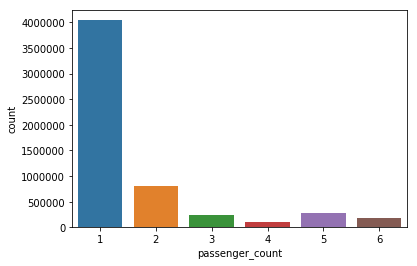

In [121]:
#What is the distribution of passenger counts?
sb.countplot(taxi_merged.passenger_count)

A majority of taxi rides are single passenger rides - suggesting that there could be room for efficiency.

Back to our original solution - let's groupby and count the number of taxis that are in the same minute, hour, and pickup and dropoff boro.

In [122]:
agg = taxi_merged.groupby(['minute','hour','dow','dom','pickup_boro','dropoff_boro','passenger_count']).size().reset_index()

In [123]:
agg = agg.rename(columns={0:'counts'})

In [124]:
agg.head(10)

,minute,hour,dow,dom,pickup_boro,dropoff_boro,passenger_count,counts
0,0,0,0,13,Carnegie Hill,Yorkville,1,1
1,0,0,0,13,Chelsea,Chelsea,1,1
2,0,0,0,13,Chelsea,Civic Center,1,1
3,0,0,0,13,Chelsea,Clinton,1,1
4,0,0,0,13,Chelsea,Gramercy,1,1
5,0,0,0,13,Chelsea,Midtown South,6,1
6,0,0,0,13,Chelsea,West Village,1,1
7,0,0,0,13,Chinatown,Greenwich Village,1,1
8,0,0,0,13,Chinatown,Midtown,1,1
9,0,0,0,13,Civic Center,East Village,1,1


With the aggregated data, let's assume:
If passenger count = 1, the number of rides could be grouped into one ride "i.e. divided by 6."
If passenger count = 2, the counts could be divded by 3.
If passenger count = 3, the counts could be divided by 2.
If passenger count >=4, the ride will be left alone.

Then, round the resulting number up by one to determine the consolidated number of rides.

In [125]:
def regroup(data):
    if data.passenger_count ==1:
        return math.ceil(data.counts/6)
    if data.passenger_count ==2:
        return math.ceil(data.counts/3)
    if data.passenger_count ==3:
        return math.ceil(data.counts/2)
    if data.passenger_count >=4:
        return data.counts
    else:
        return 0

In [126]:
agg['cat'] = agg.parallel_apply(lambda row: regroup(row),axis=1)

In [127]:
agg.sort_values(by='cat', ascending=False).head(10)

,minute,hour,dow,dom,pickup_boro,dropoff_boro,passenger_count,counts,cat
2285392,28,15,6,12,Upper West Side,Upper West Side,6,4,4
2526582,31,16,6,12,Chelsea,Midtown South,5,4,4
2980420,37,9,4,17,Lincoln Square,Murray Hill,5,4,4
913603,11,13,0,27,Lincoln Square,Lincoln Square,5,4,4
2013982,25,6,0,20,Midtown South,Midtown,6,3,3
3880134,48,10,6,26,Lincoln Square,Clinton,5,3,3
630108,7,22,0,27,Midtown South,Midtown,6,3,3
3791522,47,9,0,27,Turtle Bay,Tudor City,5,3,3
2896357,36,8,4,24,Midtown South,Midtown,5,3,3
3791325,47,9,0,20,Turtle Bay,Murray Hill,6,3,3


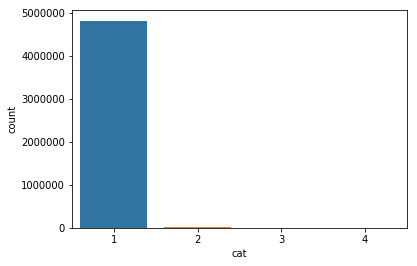

In [129]:
sb.countplot(agg.cat)

In [130]:
#What is the percent reduction in rides?
(taxi_merged.shape[0] - sum(agg.cat)) / taxi_merged.shape[0]

0.14683542605306743

This is approximately a 14.6% reduction using some simple grouping logic! However, we can see from the barplot above that there are still a number of single person rides. What if we tried grouping together rides within 5 minutes of one another?

In [131]:
taxi_merged['5_minute'] = 5 * round(taxi_merged.minute/5)

In [132]:
agg_5 = taxi_merged.groupby(['5_minute','hour','dow','dom','pickup_boro','dropoff_boro','passenger_count']).size().reset_index()
agg_5 = agg_5.rename(columns={0:'counts'})
agg_5['cat'] = agg_5.parallel_apply(lambda row: regroup(row),axis=1)

In [133]:
#What is the percent reduction in rides?
(taxi_merged.shape[0] - sum(agg_5.cat)) / taxi_merged.shape[0]

0.36787052120930064

In [192]:
#What is the efficiency increase?
sum(agg.cat)/taxi_merged.shape[0]

0.8531645739469326

This almost tripled the efficiency - great!

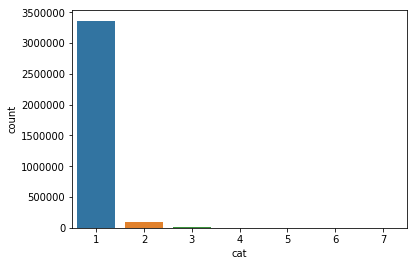

In [134]:
sb.countplot(agg_5.cat)

We still see that there are many single person rides. Let's compute an efficiency column for each combination, that is percent reduction in vehicles from taxi to Via.

In [193]:
agg_5['eff'] = (agg_5.counts-agg_5.cat)/agg_5.counts

In [203]:
agg_5.sort_values(by='eff', ascending=False).head(300)

,5_minute,hour,dow,dom,pickup_boro,dropoff_boro,passenger_count,counts,cat,eff
1432900,25.00,11,4,17,Clinton,Chelsea,1,6,1,0.83
2262102,40.00,9,6,26,Clinton,Midtown South,1,6,1,0.83
1987361,35.00,10,4,24,Upper West Side,Lincoln Square,1,6,1,0.83
952754,15.00,18,1,28,Lenox Hill,Lenox Hill,1,6,1,0.83
1737205,30.00,13,1,28,Tudor City,Sutton Place,1,6,1,0.83
2541328,45.00,9,1,28,Yorkville,Tudor City,1,6,1,0.83
42402,0.00,8,2,22,Sutton Place,Midtown,1,6,1,0.83
103731,0.00,15,2,22,Sutton Place,Lenox Hill,1,6,1,0.83
414083,5.00,20,1,14,Midtown South,Clinton,1,6,1,0.83
2297480,40.00,12,4,17,Greenwich Village,Midtown South,1,6,1,0.83


In [195]:
#How does efficiency vary by time?
avg = agg_5[['hour','eff']].groupby('hour').mean()

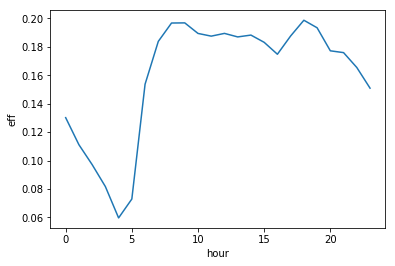

In [196]:
sb.lineplot(x=avg.index,y=avg.eff)

In [209]:
#How does efficiency vary by location?
avg_loc = agg_5[['pickup_boro','eff']].groupby('pickup_boro').mean()

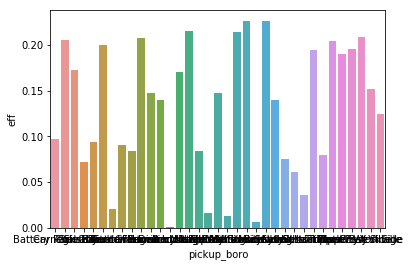

In [215]:
sb.barplot(x=avg_loc.index, y=avg_loc.eff)

This is very difficult to interpret - let's map it onto a map.

In [220]:
boros = centroids[['Name','latitude','longitude']]
export = pd.merge(agg_5, boros, left_on='pickup_boro', right_on='Name')

In [ ]:
export.to_csv("agg_map.csv")